In [2]:
pip install darts torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 71.8 MB/s eta 0:00:00


In [3]:

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import TFTModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae, rmse

from pytorch_lightning.callbacks import EarlyStopping

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


CUDA available: True
GPU: NVIDIA A100-SXM4-40GB


In [4]:
df = pd.read_csv(
    "electricity_features_hourly.csv",
    parse_dates=["Date"]
)

df = df.sort_values("Date").reset_index(drop=True)

# Sadece leakage yaratmayan ham kolonlar
base_cols = [
    "Date",
    "consumption",
    "temperature",
    "humidity",
    "hour_sin", "hour_cos",
    "month_sin", "month_cos",
    "is_weekend", "is_holiday"
]

df = df[base_cols]

# Float32 zorla (GPU ve stabilite için)
for col in df.columns:
    if col != "Date":
        df[col] = df[col].astype(np.float32)

In [5]:
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx].copy()
val_df   = df.iloc[split_idx:].copy()

In [6]:
# 4️⃣ LAG & ROLLING FEATURE FONKSİYONU
def add_lag_features(data):
    data["lag_1h"]   = data["consumption"].shift(1)
    data["lag_24h"]  = data["consumption"].shift(24)
    data["lag_168h"] = data["consumption"].shift(168)

    data["rolling_mean_24h"] = data["consumption"].rolling(24).mean()
    data["rolling_mean_7d"]  = data["consumption"].rolling(168).mean()
    return data

In [7]:
train_df = add_lag_features(train_df)

In [8]:
# 6️⃣ VALIDATION LAG & ROLLING (LEAKAGE YOK)
history = train_df.tail(168).copy()
val_with_history = pd.concat([history, val_df], axis=0)
val_with_history = add_lag_features(val_with_history)

val_df = val_with_history.iloc[168:].copy()

In [9]:
train_df = train_df.dropna().reset_index(drop=True)
val_df   = val_df.dropna().reset_index(drop=True)

In [10]:
# Target
target_train = TimeSeries.from_dataframe(
    train_df, "Date", "consumption", freq="H"
)
target_val = TimeSeries.from_dataframe(
    val_df, "Date", "consumption", freq="H"
)

# Past covariates
past_cols = [
    "temperature", "humidity",
    "lag_1h", "lag_24h", "lag_168h",
    "rolling_mean_24h", "rolling_mean_7d"
]

past_train = TimeSeries.from_dataframe(
    train_df, "Date", past_cols, freq="H"
)
past_val = TimeSeries.from_dataframe(
    val_df, "Date", past_cols, freq="H"
)

# Future covariates
future_cols = [
    "hour_sin", "hour_cos",
    "month_sin", "month_cos",
    "is_weekend", "is_holiday"
]

future_train = TimeSeries.from_dataframe(
    train_df, "Date", future_cols, freq="H"
)
future_val = TimeSeries.from_dataframe(
    val_df, "Date", future_cols, freq="H"
)


/usr/local/lib/python3.12/dist-packages/darts/timeseries.py:5145: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_times = resampled_times.asfreq(freq)
/usr/local/lib/python3.12/dist-packages/darts/timeseries.py:5145: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_times = resampled_times.asfreq(freq)
/usr/local/lib/python3.12/dist-packages/darts/timeseries.py:5145: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_times = resampled_times.asfreq(freq)
/usr/local/lib/python3.12/dist-packages/darts/timeseries.py:5145: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_times = resampled_times.asfreq(freq)
/usr/local/lib/python3.12/dist-packages/darts/timeseries.py:5145: FutureWarning: 'H' is deprecated and will be removed in a future version, please u

In [11]:
scaler_target = Scaler()
scaler_past = Scaler()
scaler_future = Scaler()

target_train = scaler_target.fit_transform(target_train)
target_val   = scaler_target.transform(target_val)

past_train = scaler_past.fit_transform(past_train)
past_val   = scaler_past.transform(past_val)

future_train = scaler_future.fit_transform(future_train)
future_val   = scaler_future.transform(future_val)

# Float32 güvenliği
target_train = target_train.astype(np.float32)
target_val   = target_val.astype(np.float32)
past_train   = past_train.astype(np.float32)
past_val     = past_val.astype(np.float32)
future_train = future_train.astype(np.float32)
future_val   = future_val.astype(np.float32)

In [12]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    verbose=True
)

In [13]:
model = TFTModel(
    input_chunk_length=96,
    output_chunk_length=24,
    hidden_size=64,
    lstm_layers=2,
    num_attention_heads=8,
    dropout=0.1,
    batch_size=256,
    n_epochs=50,
    random_state=42,
    add_relative_index=True,

    pl_trainer_kwargs={
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        "devices": 1,
        "precision": 32,    # 🔒 bf16 KAPALI → dtype hatası YOK
        "callbacks": [early_stopping]
    }
)



model.fit(
    series=target_train,
    past_covariates=past_train,
    future_covariates=future_train,
    val_series=target_val,
    val_past_covariates=past_val,
    val_future_covariates=future_val,
    verbose=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tenso

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.321


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.162 >= min_delta = 0.0. New best score: 0.158


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.148


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.134


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.131


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.111


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.109


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.101


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.098


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.097


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.095


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.093


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.091


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.090


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.089


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 0.089. Signaling Trainer to stop.


TFTModel(output_chunk_shift=0, hidden_size=64, lstm_layers=2, num_attention_heads=8, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, skip_interpolation=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=96, output_chunk_length=24, batch_size=256, n_epochs=50, random_state=42, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': 1, 'precision': 32, 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7949915b29f0>]})

In [15]:
full_future = future_train.append(future_val)

pred = model.predict(
    n=24,
    series=target_train,
    past_covariates=past_train,
    future_covariates=full_future
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [16]:
pred = scaler_target.inverse_transform(pred)
actual = scaler_target.inverse_transform(target_val[:24])

print("MAE :", mae(actual, pred))
print("RMSE:", rmse(actual, pred))



MAE : 7347.1406
RMSE: 10049.892


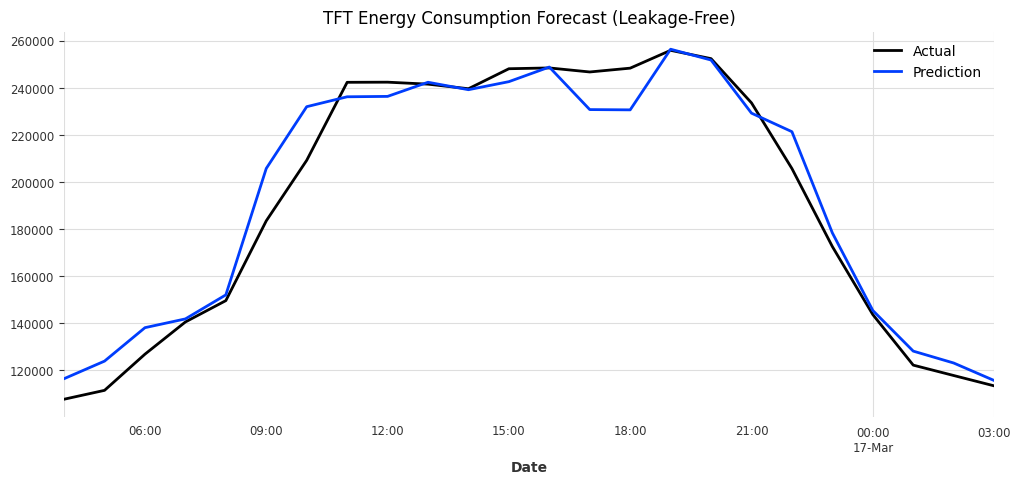

In [17]:
plt.figure(figsize=(12, 5))
actual.plot(label="Actual")
pred.plot(label="Prediction")
plt.legend()
plt.title("TFT Energy Consumption Forecast (Leakage-Free)")
plt.show()